<a href="https://colab.research.google.com/github/ManuSS88/DIO_transfer_learning/blob/main/TransferLearning_Desafio_DIO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Desafio DIO

Utilizar *transfer learning* para um classificador de imagem acurado baseado em um número relativamente pequeno de amostras de treinamento.
Utilizando o dataset cats_vs_dogs: Um grande conjunto de imagens de cães e gatos retirado do link fornecido (https://www.microsoft.com/en-us/download/details.aspx?id=54765. )
Também vou testar com as imagens de tomates verdes X tomates maduros que baixei no projeto anterior
***Transfer learning***: o processo envolve utilizar uma rede neural existente, já treinada com base em um dataset grande, como base para um novo modelo que se beneficia da acurácia de uma rede anterior.

Primeiro é necessário importar bibliotecas:

In [ ]:
%matplotlib inline
#"magic command" specific to Jupyter notebooks.It ensures that any plots or graphs generated by Matplotlib will be displayed directly within the notebook.

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

When you use TensorFlow as the Keras backend, it means that TensorFlow is the engine that's running your Keras models. All the computations, tensor operations, and optimizations are performed using TensorFlow's functionalities.

In [ ]:
import zipfile
import tarfile


In [ ]:
# prompt: open .tar dataset stored in "/content/Riped and Unriped Tomato Dataset.tar"

import tarfile

# Assuming the .tar file is in the /content directory
tar_file_path = "/content/Riped and Unriped Tomato Dataset.tar"

try:
    with tarfile.open(tar_file_path, 'r') as tar:
        tar.extractall(path="/content")  # Extract to /content directory
        print(f"Successfully extracted {tar_file_path} to /content")
except FileNotFoundError:
    print(f"Error: {tar_file_path} not found.")
except tarfile.TarError:
    print(f"Error: Could not open or extract {tar_file_path}. Check if it's a valid .tar file.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Successfully extracted /content/Riped and Unriped Tomato Dataset.tar to /content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Update the root directory to point to the extracted data
root = '/content/Riped and Unriped Tomato Dataset/Images'  # This should be the extracted folder
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
print(categories)

['/content/Riped and Unriped Tomato Dataset/Images/riped', '/content/Riped and Unriped Tomato Dataset/Images/unriped']


In [ ]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

Carregando as imagens da pasta raiz

In [ ]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

Randomizando a ordem das imagens

In [ ]:
random.shuffle(data)

gerar treinamento/validação/teste split (70%, 15%, 15%) => diz respeito a quantidade de dados que serão utilizados para treinamento, validação e teste. 70% para treinamento, 15% para validação e 15% para test

In [ ]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

Separar dados para rótulos. x_train vai armazenar as características dos dados, que são as imagens propriamente. y_train vai armazenar os rótulos, representando as categorias que cada imagem pertence. np.array converte as listas em vetores NumPy, que são eficientes para computações numéricas.

In [ ]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]


Pré-processamento dos dados para garantir que serão float32 (tipo de dados que representam números decimais que usam 32 bits de memória) e normalizados ente 0 e 1.

In [ ]:
# normalize data (dividir por 255 normaliza o valor do pixel)
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(27, 2)


Sumarizar os dados até agora

In [ ]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 177 images from 2 categories
train / validation / test split: 123, 27, 27
training data shape:  (123, 224, 224, 3)
training labels shape:  (123, 2)


Carregar algumas imagens do dataset

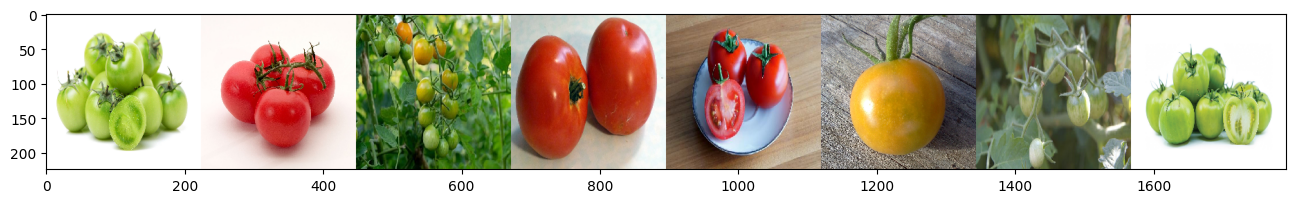

In [ ]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

Primeiro treinamento de uma rede neural do zero:
Antes do transfer learning, é preciso construir uma rede neural do zero para classificar o dataset. Isso fornecerá um baseline para comparar com a rede transferida.
Será construída uma rede contendo 4 camadas convolucionais e max-pooling alternadas. Após a última camada de pooling, será anexada uma camada totalmente conectada com 256 neurônios, outra camada de dropout e, finalmente, uma camada de classificação softmax para as classes.

In [ ]:
# build the network
from keras.models import Sequential
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 222, 222, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 109, 109, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 52, 52, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,209,058 (4.61 MB)

 Trainable params: 1,209,058 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

Um network médio com 1.2 milhões de pesos e vieses (os parametros) foi criado. Maior parte está levando a uma camada totalmente conectada pre-softmax "dense_1"
Podemos treinar nosso modelo para 10 épocas com a um batch size de 128. Preciso registrar o histórico para plotar a perda ao longo do tempo.


In [ ]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=15,
                    validation_data=(x_val, y_val))

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.9187 - loss: 0.1980 - val_accuracy: 0.9630 - val_loss: 0.0961
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.9675 - loss: 0.1293 - val_accuracy: 0.9630 - val_loss: 0.1255
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.9268 - loss: 0.2093 - val_accuracy: 0.9630 - val_loss: 0.1192
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.9675 - loss: 0.1773 - val_accuracy: 0.9630 - val_loss: 0.1130
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.9593 - loss: 0.1297 - val_accuracy: 0.9630 - val_loss: 0.1157
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.9675 - loss: 0.0778 - val_accuracy: 0.9630 - val_loss: 0.1309
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.9756 - loss: 0.0771 - val_accuracy: 0.9630 - val_loss: 0.1614
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.9593 - loss: 0.1012 - val_accuracy: 0.9630 - val_loss: 0.1871
Epoch 9/

Plotando a perda e acurácia de validação ao longo do tempo

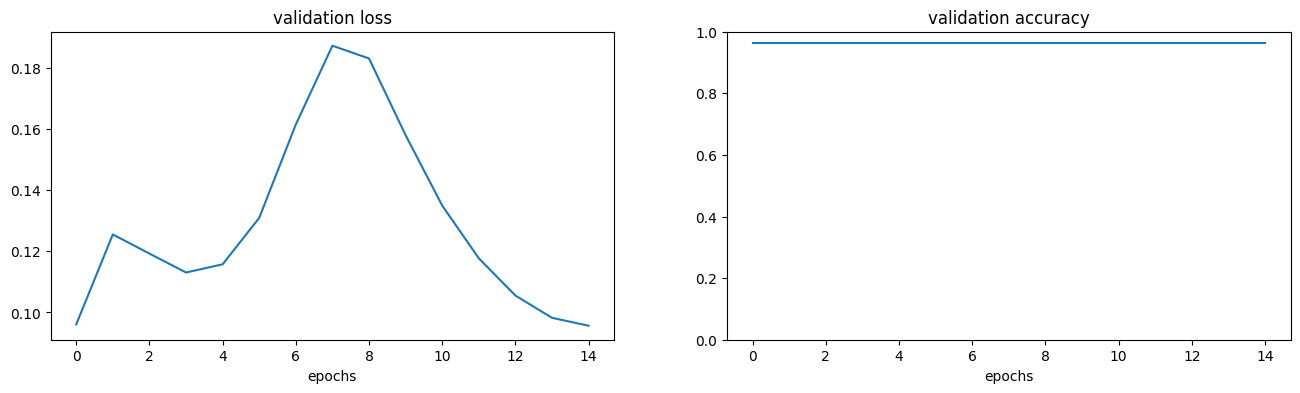

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

A perda começa a aumentar depois de 9 épocas, apesar da validação de acurácia permanecer maior que 90%.
Isso sugere que nosso modelo começa a overfitting em torno dessa época, e a melhor performance seria alcançada se tivesse parado antes.
Podemos ter uma avaliação final do modelo no conjunto de treinamento

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss) #o resultado para o data set de tomates foi 0.0521, um valor muito baixo. representa a diferença média entre as predições e os rótulos reais.
print('Test accuracy:', accuracy) # o resultado foi de 1, o que significa que o modelo atingiu 100% de acurácia no conjunto teste.

Test loss: 0.052149053663015366
Test accuracy: 1.0


TRANSFER LEARNING
Agora seguimos para classificar a partir de uma rede já treinada.
Será carregado o VGG16 do keras, que foi treinado no ImageNet e os pesos estão salvos online.

In [ ]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

Para tarefa, a camada de classificação final é removida, a camada softmax de 1000 neurônios no final, que corresponde ao ImageNet, e é substituída por uma nova camada softmax para o conjunto de dados de tomates.

In [ ]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


Nós vamos retreinar esta rede, model_new, no novo conjunto de dados e rótulos. Mas primeiro, precisamos congelar os pesos e vieses em todas as camadas da rede, exceto a nossa nova camada no final, com a expectativa de que as características que foram aprendidas na VGG ainda sejam bastante relevantes para a nova tarefa de classificação de imagens. Não é o ideal, mas provavelmente é melhor do que o que podemos treinar em nosso conjunto de dados limitado.
By setting the `trainable` flag in each layer false (except our new classification layer), we ensure all the weights and biases in those layers remain fixed, and we simply train the weights in the one layer at the end. In some cases, it is desirable to *not* freeze all the pre-classification layers. **If your dataset has enough samples, and doesn't resemble ImageNet very much, it might be advantageous to fine-tune some of the VGG layers along with the new classifier, or possibly even all of them. To do this, you can change the below code to make more of the layers trainable.**

In [ ]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

Additionally, we still have roughly 134 million weights, but now the vast majority of them are "non-trainable params" because we froze the layers they are contained in. We now only have 397,000 trainable parameters, which is actually only a quarter of the number of parameters needed to train the first model.
As before, we go ahead and train the new model, using the same hyperparameters (batch size and number of epochs) as before, along with the same optimization algorithm. We also keep track of its history as we go.

In [ ]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=15,
                         validation_data=(x_val, y_val))


Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 87s 87s/step - accuracy: 0.5691 - loss: 0.7643 - val_accuracy: 0.3704 - val_loss: 1.7563
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 143s 143s/step - accuracy: 0.4309 - loss: 1.6312 - val_accuracy: 0.3704 - val_loss: 0.8906
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 144s 144s/step - accuracy: 0.4065 - loss: 0.8401 - val_accuracy: 0.6296 - val_loss: 0.7209
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 137s 137s/step - accuracy: 0.5691 - loss: 0.8019 - val_accuracy: 0.6296 - val_loss: 0.9497
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 148s 148s/step - accuracy: 0.5691 - loss: 1.0889 - val_accuracy: 0.6296 - val_loss: 0.8683
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 140s 140s/step - accuracy: 0.5691 - loss: 0.9862 - val_accuracy: 0.6296 - val_loss: 0.6483
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 142s 142s/step - accuracy: 0.5691 - loss: 0.6950 - val_accuracy: 0.7407 - val_loss: 0.6442
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 139s 139s/step - accuracy: 0.7398 - loss: 0.6021 - val_accuracy: 0.3704 - val

A acurácia do teste diminuiu consideravelmente e a perda aumentou

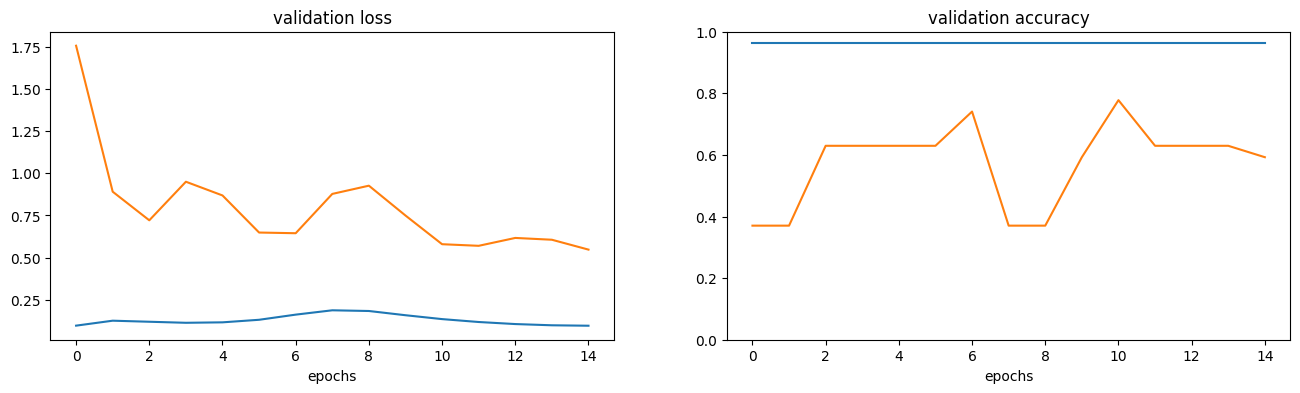

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Teste de validação final --> acurácia caiu para 55% e a perda aumentou para 0.68

In [ ]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.6875520348548889
Test accuracy: 0.5555555820465088


Para prever uma imagem do dataset

In [ ]:
img, x = get_image('/content/Riped and Unriped Tomato Dataset/Images/riped/riped_tomato_1.jpeg')
probabilities = model_new.predict([x])
probabilities

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


array([[0.14969945, 0.85030055]], dtype=float32)

Segundo esse resultado, o modelo previu com 85% de confiança o que é um tomate maduro e com 15% de confiança o que é um tomate verde.